## Import Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

## Load Data

In [124]:
changeJobDf = pd.read_csv('A2_change_job_labeled.csv')

## EDA

In [125]:
print("--- Dataset Overview ---")
changeJobDfCount = changeJobDf.shape[0]
print(f"Number of training data rows: {changeJobDfCount}...")

print("\n--- Checking for null values ---")
missingCount = changeJobDf.isna().sum()
missingCount = len(missingCount[missingCount > 1])
print(f"Missing values in train df: {missingCount}...")

print("\n--- Checking for empty/whitespace-only reviews ---")
emptyCountTrainCount = changeJobDf.eq('').sum()
emptyCountTrainCount = len(emptyCountTrainCount[emptyCountTrainCount > 1])
print(f"Number of empty/whitespace-only reviews: {emptyCountTrainCount}...")

print("\n--- Checking for duplicates ---")
duplicateRowCount = changeJobDf.duplicated().sum()
print(f"Number of duplicate rows: {duplicateRowCount}...")

--- Dataset Overview ---
Number of training data rows: 11494...

--- Checking for null values ---
Missing values in train df: 0...

--- Checking for empty/whitespace-only reviews ---
Number of empty/whitespace-only reviews: 0...

--- Checking for duplicates ---
Number of duplicate rows: 0...


## Check Depndendent/Target Variable Distribution

Target distribution: target
no     8676
yes    2818
Name: count, dtype: int64


Text(0, 0.5, 'Count')

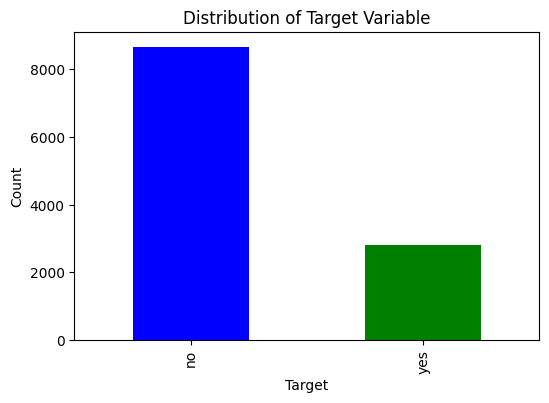

In [126]:
# Calculate value counts
targetCounts = changeJobDf['target'].value_counts()
print(f"Target distribution: {targetCounts}")

# Create the plot
plt.figure(figsize=(6, 4))

# Use a bar chart
targetCounts.plot(kind='bar', color=['Blue', 'Green'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

## Check unique values for non numeric fields

In [127]:
nonNumericCols = changeJobDf.select_dtypes(exclude=[np.number]).columns
print("--- Non-numeric Field Unique Values ---")
for col in nonNumericCols:
    print(f"{col}: {changeJobDf[col].unique()}")

--- Non-numeric Field Unique Values ---
gender: ['Male' 'Other' 'Female']
enrolled_university: ['No enrollment' 'Full time' 'Part time']
education_level: ['Undergraduate' 'High School' 'PhD' 'Primary School' 'Masters']
academic_discipline: ['STEM' 'No major' 'Humanities' 'Other' 'Business degree' 'Arts']
experience: ['15' '4' '8' '2' '7' '5' '13' '3' '6' '19' '>20' '1' '16' '20' '10' '<1'
 '9' '11' '18' '14' '17' '12']
company_size: ['100-500' '50-99' '5000-9999' '500-999' '10000+' '<10' 'Oct-49'
 '1000-4999']
company_type: ['NGO' 'Funded startup' 'Pvt Ltd' 'Public sector' 'Early stage startup'
 'Other']
last_new_job: ['1' '>4' 'never' '2' '4' '3']
relevant_experience: ['Has relevant experience' 'No relevant experience']
target: ['no' 'yes']


## Create Ordinal Mappings

In [128]:
# Ordinal mappings
companySizeMap = {'<10': 0, 'Oct-49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7}
lastNewJobMap = {'never': 0, '1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
educationMap = {'Primary School': 0, 'High School': 1, 'Undergraduate': 2, 'Masters': 3, 'PhD': 4}

# Apply mappings to ordinal fields
changeJobDf['company_size'] = changeJobDf['company_size'].map(companySizeMap)
changeJobDf['last_new_job'] = changeJobDf['last_new_job'].map(lastNewJobMap)
changeJobDf['education_level'] = changeJobDf['education_level'].map(educationMap)

# Define ordinal cols and create a list of non-numeric cols without ordinals
ordinalCols = ['company_size','last_new_job','education_level']
labelEncodeCols = [col for col in nonNumericCols if col not in ordinalCols]

# Transform categorical columns
le = preprocessing.LabelEncoder()

# Apply transformations
for col in labelEncodeCols:
    changeJobDf[col] = le.fit_transform(changeJobDf[col])

print("--- Non-numeric Field Post Transformation Values ---")
for col in nonNumericCols:
    print(f"{col}: {changeJobDf[col].unique()}")

--- Non-numeric Field Post Transformation Values ---
gender: [1 2 0]
enrolled_university: [1 0 2]
education_level: [2 1 4 0 3]
academic_discipline: [5 3 2 4 1 0]
experience: [ 6 14 18 11 17 15  4 13 16 10 21  0  7 12  1 20 19  2  9  5  8  3]
company_size: [3 2 6 4 7 0 1 5]
company_type: [2 1 5 4 0 3]
last_new_job: [1 5 0 2 4 3]
relevant_experience: [0 1]
target: [0 1]


## Seperate Feature cols and target col

In [129]:
targetCol = changeJobDf.columns[-1]
featureCols = changeJobDf.columns[:-1]

## Correaltion Analysis

In [130]:
corrMatrix = changeJobDf.corr()
targetCorr = corrMatrix[targetCol].sort_values(ascending=False)
targetCorr = targetCorr.drop(labels=[targetCol]) # Excluding target from matrix as this is redundant

print(f"--- Top features positively correlated with {targetCol} ---")
print(targetCorr.head(10))

print(f"\n --- Top features negatively correlated with {targetCol} --- ")
print(targetCorr.tail(10))

--- Top features positively correlated with target ---
city.326               0.322135
relevant_experience    0.138455
city.2119              0.084905
city.128               0.065363
city.142               0.062480
city.105               0.043956
city.74                0.041877
company_size           0.039761
city.2341              0.032755
city.699               0.030747
Name: target, dtype: float64

 --- Top features negatively correlated with target --- 
city.102                 -0.043070
city.328                 -0.043381
city.104                 -0.046510
company_type             -0.051647
city.134                 -0.057197
last_new_job             -0.082293
city.96                  -0.084513
city.114                 -0.096497
enrolled_university      -0.132326
city_development_index   -0.345993
Name: target, dtype: float64


## Mutual Information Score

/Users/mathiasmorgan/Desktop/Applied Data Science/ITO5149 - Applied Data Analysis/Assessment 2/A2_data_demo_code/venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


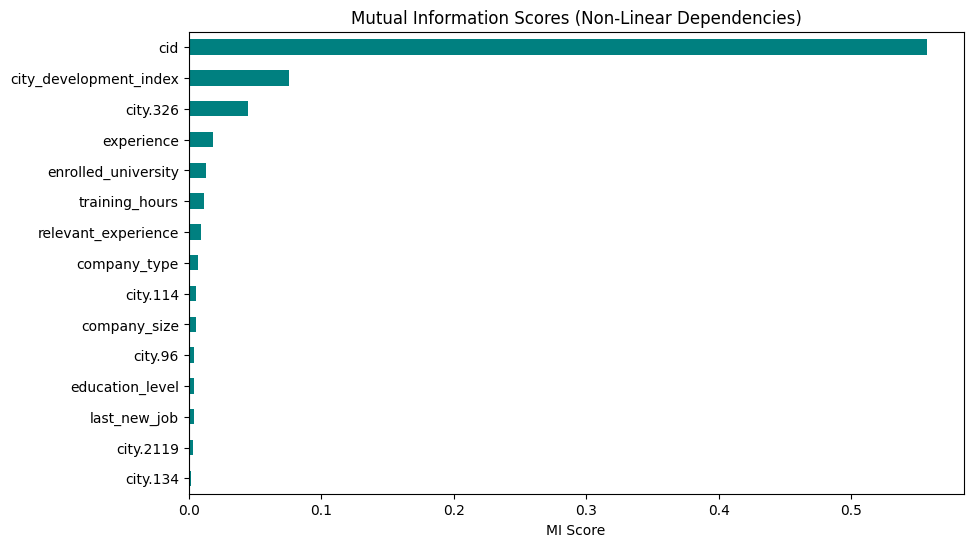

In [131]:
miScores = mutual_info_classif(changeJobDf[featureCols], changeJobDf[targetCol], discrete_features=True, random_state=42)
miSeries = pd.Series(miScores, index=changeJobDf[featureCols].columns)
miSeries = miSeries.sort_values(ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
miSeries.head(15).plot(kind='barh', color='teal')
plt.title("Mutual Information Scores (Non-Linear Dependencies)")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()